In [19]:
import numpy as np 
import matplotlib.pyplot as plt 
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from tqdm.notebook import tnrange, tqdm_notebook
from types import SimpleNamespace  

In [20]:
class GGParamter:
    
    def __init__(self, intial_value):
        self.value = intial_value
        self.fixed = True
        
    def fix(self):
        self.fix = True
        return self
        
    def free(self):
        self.fix = False
        return self        
        
class GGDesignOptimizer:
    
    # Solver parameters
    mu = 1e-3
    h = 1e-5
    
    def __init__(self, parameters, reward_function):
       self.parameters = parameters
       self.reward_function = reward_function

class CalculateReward:
    
    rho = 1.77e-8 # [Ohm / m]
    
    def __init__(self, start, end, samples):
        freq = np.logspace(3, 7, 1000)  #[Hz]
        self.omega = 2*np.pi*freq
        
    def Lp(self, dp): # [H]
        rp      = dp['rp'].value    # External radius of flat spiral coil
        Np      = dp['Np'].value    # Primary windings
        return rp**2 * (Np/2)**2 / (9/4*Np + 10*rp)*10e-6
    
    def Ls(self, dp):
        rs      = dp['rs'].value    # Radius of secondary coil winding
        Ns      = dp['Ns'].value    # Secondary windings
        r_ws    = dp['r_ws'].value  # Radius of secondary wire cross-section
        
        l = r_ws * 2 * Ns 
        return Ns**2 / l * np.pi * rs**2 * 4*np.pi*1e-7
    
    def Rs(self, dp):
        r_ws    = dp['r_ws'].value  
        rs      = dp['rs'].value
        Ns      = dp['Ns'].value
        
        A = np.pi * r_ws**2
        l = 2 * np.pi * rs * Ns 
        return self.rho * l / A
    
    def Rp(self, dp):
        r_wp    = dp['r_wp'].value  # Radius of primary wire cross-section
        rp      = dp['rp'].value    
        Np      = dp['Np'].value
        
        A = np.pi * r_wp**2
        l = np.pi * 2 * rp * np.sqrt(1 + (Np / (2 * np.pi)**2))
        return self.rho * l / A
    
    def __tf2db(T):
        return 20 * np.log10(np.abs(T))
    
    def evaluate_model(self, dp):
        tf = self.get_tf(dp)
        tf_db = self.__tf2db(tf)
        return np.max(tf_db)

    def get_tf(self, dp):
        Lp = self.Lp(dp)
        Ls = self.Ls(dp)
        Rp = self.Rp(dp)
        Rs = self.Rs(dp)
        
        Cp = dp['Cp'].value
        Cs = dp['Cs'].value
        k = 0.1
        
        def X_L(omega, L):
            return 1j*omega*L 

        def X_C(omega,C):
            return 1/(1j*omega*C)
        
        M = k*np.sqrt(Lp*Ls)
        Zp_star = X_C(self.omega, Cp) + Rp + X_L(self.omega, (Lp - M))
        Zs_star = Rs + X_L(self.omega, (Ls - M))
        return 1/((Zp_star + X_L(self.omega, M)) /X_L(self.omega, M) * (1+X_L(self.omega, Cs)*(Zs_star + X_L(self.omega, M))) - ((1j*self.omega)**2)*Cs*M)



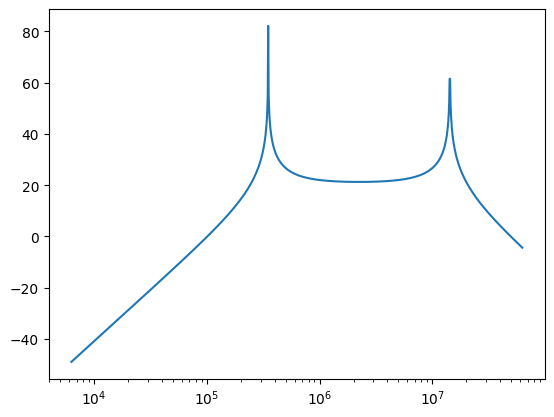

In [21]:
design_parameters = {
    'Np'    : GGParamter(10).free(),
    'rp'    : GGParamter(0.2).free(),
    'Ns'    : GGParamter(1000).free(),
    'rs'    : GGParamter(0.05).free(),
    'Cs'    : GGParamter(1e-12).free(),
    'Cp'    : GGParamter(12e-5).free(),
    'r_ws'  : GGParamter(1e-3),
    'r_wp'  : GGParamter(1e-2)
}

cr = CalculateReward(3, 7, 100)